In [15]:
from deepcake.umeyama import umeyama
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [323]:
image = cv2.cvtColor(cv2.resize(cv2.imread("data/cropped_frames/elon/1.jpg"), (256,256)), cv2.COLOR_BGR2RGB)

## This notebook is meant to explain 2 things:
1. The image warping process used to *distort the input image*
2. Generating a target image such that it's MSE loss w.r.t the distorted input image is minimized.Thanks to the umeyama algorithm, we are able to do this without distorting the key visual features. 

**Note**: I'm neither a scientist nor an expert. I wrote this notebook to explain the process and it's significance to myself in simple words. If you find any errors, feel free to [reach out to me](mailto:mayukhmainak2000@gmail.com)

## Step 1: warping the original image 

For this, we first generate 2 simple mappings for the x and y axes of the image. The image shown below are the mappings which represent the indices between values `128 - 80` and `128 + 80`.

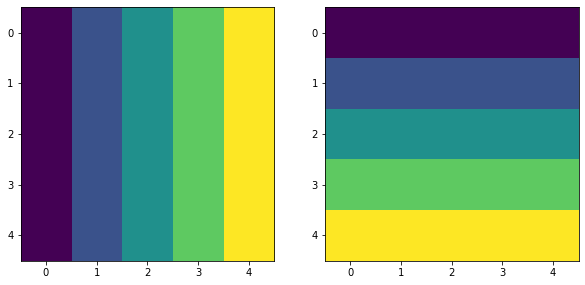

In [324]:
assert image.shape == (256, 256, 3)
range_ = np.linspace(128 - 80, 128 + 80, 5)

mapx = np.broadcast_to(range_, (5, 5))
mapy = mapx.T

plt.rcParams['figure.figsize'] = 10,5
fig, ax = plt.subplots(nrows=1, ncols=2)

ax.flat[0].imshow(mapx)
ax.flat[1].imshow(mapy)


## Injecting noise into the index mapping 
This was done using `np.random.normal`. The argument `scale` corresponds to the standard deviation. 

In case you didn't know already, standard deviation is a measure of the amount of variation or dispersion of a set of values. A low standard deviation indicates that the values tend to be close to the mean of the set. 

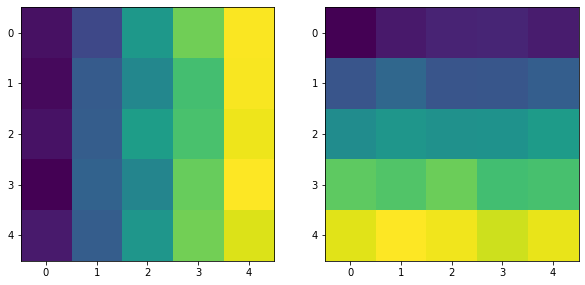

In [325]:

mapx = mapx + np.random.normal(size=(5, 5), scale=5)
mapy = mapy + np.random.normal(size=(5, 5), scale=5)

plt.rcParams['figure.figsize'] = 10,5
fig, ax = plt.subplots(nrows=1, ncols=2)

ax.flat[0].imshow(mapx)
ax.flat[1].imshow(mapy)


## Interpolating the index mapping into a larger size i.e the size of the original image

This is done in the following steps:
* Resizing the maps to size `(80,80)`
* Cropping the maps to be of size `(64,64)` with `[8:72, 8:72]`

This gives us 2 maps which are of size `(64,64)`, but contain indices well in between (and not including) `0` and `255`

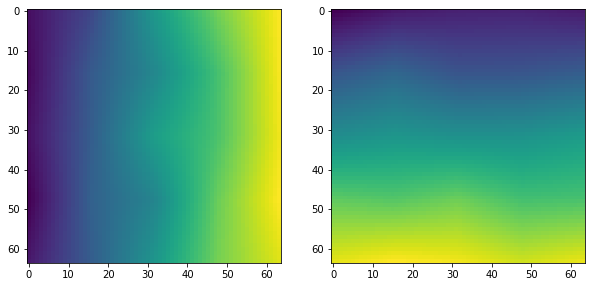

In [326]:
interp_mapx = cv2.resize(mapx, (80, 80))[8:72, 8:72].astype('float32')
interp_mapy = cv2.resize(mapy, (80, 80))[8:72, 8:72].astype('float32')

plt.rcParams['figure.figsize'] = 10,5
fig, ax = plt.subplots(nrows=1, ncols=2)

ax.flat[0].imshow(interp_mapx)
ax.flat[1].imshow(interp_mapy)



## Step 2: Applying the index mapping into the original image

This would in turn also resize the image from `(256,256)` to `(64,64)`. Notice the sizes in the axes.

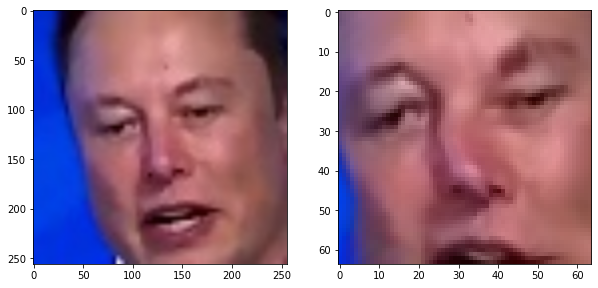

In [327]:

warped_image = cv2.remap(image, interp_mapx, interp_mapy, cv2.INTER_LINEAR)
plt.rcParams['figure.figsize'] = 10,5
fig, ax = plt.subplots(nrows=1, ncols=2)

ax.flat[0].imshow(image)
ax.flat[1].imshow(warped_image)


## Visualizing the distortion with a scatter plot

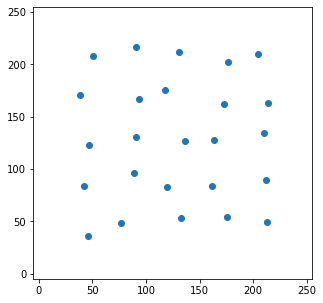

In [328]:

src_points = np.stack([mapx.ravel(), mapy.ravel()], axis=-1)

src_points_x = src_points[:,0]
src_points_y = src_points[:,1]
plt.rcParams['figure.figsize'] = 5, 5

plt.scatter(src_points_x, src_points_y)
plt.xlim(-5,255)
plt.ylim(-5,255)
# plt.axis("off")
plt.show()

## Comparing the distorted points with a uniform grid of size `(64,64)`

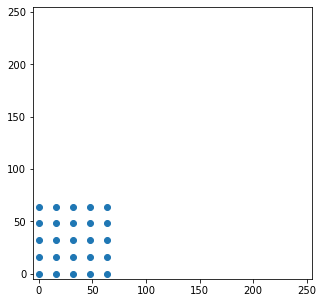

In [329]:
dst_points = np.mgrid[0:65:16, 0:65:16].T.reshape(-1, 2)

dst_points_x = dst_points[:,0]
dst_points_y = dst_points[:,1]

plt.scatter(dst_points_x, dst_points_y)
plt.xlim(-5,255)
plt.ylim(-5,255)
# plt.axis("off")

plt.show()

Text(0.5, 1.0, 'distorted image pattern')

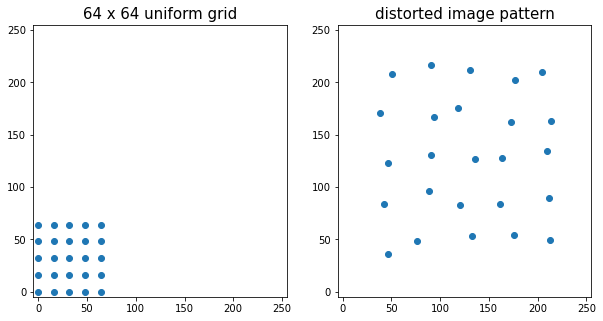

In [330]:

plt.rcParams['figure.figsize'] = 10,5
fig, ax = plt.subplots(nrows=1, ncols=2)
ax.flat[0].scatter(dst_points_x, dst_points_y)
ax.flat[0].set_ylim(-5, 255)
ax.flat[0].set_xlim(-5, 255)
ax.flat[0].set_title("64 x 64 uniform grid", fontsize = 15)

ax.flat[1].scatter(src_points_x, src_points_y)
ax.flat[1].set_ylim(-5, 255)
ax.flat[1].set_xlim(-5, 255)
ax.flat[1].set_title("distorted image pattern", fontsize = 15)

## And then Mr. Shinji Umeyama asked:

**If 2 point patterns are given, what is the set of similarity transformation parameters that give the least mean squared error between the patterns ?**

And this is exactly what the umeyama algorithm does, it finds a set of similarity transformation parameters (rotation, translation, scaling) that minimizes the MSE Loss between the patterns. 


## First let us understand it with the help of a dummy example with 2 simple set of points `p1` and `p2`

The set `p2` was made by scaling `p1` by a factor of 2.5 and then adding some random noise to it 

In [331]:
p1 = np.array([
    [0.7,1],
    [2,2.3],
    [0.8, 2.0]
])

p1_x = p1[:,0]
p1_y = p1[:,1]


p2 = p1*2.5  ##scaling
noise = np.random.normal(size= (3,2), scale = 0.3)   ## noise 
p2 += noise 

p2_x = p2[:,0]
p2_y = p2[:,1]


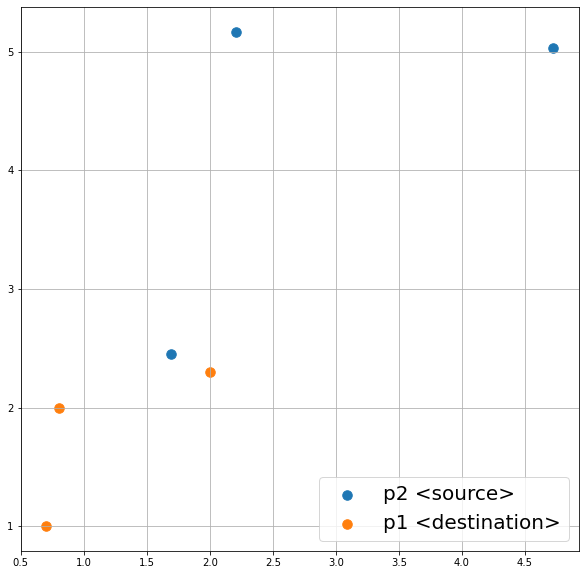

In [332]:
plt.rcParams['figure.figsize'] = 10,10

plt.scatter(p2_x, p2_y, label = "p2 <source>", s = 90)
plt.scatter(p1_x, p1_y, label = "p1 <destination>", s = 90)
plt.legend(fontsize = 20)
plt.grid()

## Using the `umeyama()` function

This function applies the umeyama algorithm as stated in [this paper](https://pdfs.semanticscholar.org/d107/231cce2676dbeea87e00bb0c587c280b9c53.pdf)

In [333]:
transforms = umeyama(p2, p1, True)[:2]
transforms

array([[ 0.43741371, -0.05871987,  0.15619847],
       [ 0.05871987,  0.43741371, -0.24702636]])

## Now what do these transformations mean ? 


```
[[size, rotation, location], ←x-axis
[rotation, size, location]] ←y-axis
```

A default matrix or one that wouldn’t change anything would look like;

```
[[1, 0, 0]
 [0, 1, 0]]
```

Or if we want to alter just the width, it  would look like:

```
[[0.5, 0, 0], #x 
 [0, 1, 0]]   #y
```

Our transformation matrix is :

```
array([[ 0.42227109, -0.01604394, -0.01891083],
       [ 0.01604394,  0.42227109, -0.27922311]])
```
Which means: 
* **Along the x axis**:
    * scale it by a factor of `0.42227109`
    * rotate it by a factor of `-0.01604394`
    * translate `-0.01891083` units
* **Along the Y axis**:
    * rotate it by a factor of `0.01604394`
    * scale it by a factor of `-0.27922311`
    * translate `-0.279223113` units
    
We're taking only the first 2 indices of the transformation matrix because the third one represents the set of transformations required on the z axis, which would be `[0,0,1]`

Check out [this article](https://towardsdatascience.com/transformations-with-opencv-ff9a7bea7f8b) to know more about them

In [334]:
def rotate(p, origin=(0, 0), rad_angle=0):
    angle = rad_angle
    R = np.array([[np.cos(angle), -np.sin(angle)],
                  [np.sin(angle),  np.cos(angle)]])
    o = np.atleast_2d(origin)
    p = np.atleast_2d(p)
    return np.squeeze((R @ (p.T-o.T) + o.T).T)

def transform(points, transformation_matrix):
    
    p_rotating = rotate(points, rad_angle = transformation_matrix[0][1])
    p_rotated = rotate(points, rad_angle = transformation_matrix[1][0])
    
    p_x = p_rotated[:, 0]
    p_y= p_rotated[:, 1]
    
    p_x *= transformation_matrix[0][0]
    p_y *= transformation_matrix[1][1]
    
    p_x += transformation_matrix[0][2]
    p_y += transformation_matrix[1][2]
    
    return p_x, p_y

## Testing out the transformation matrix on the points 
1. We start out by **rotating** the set of points (p2)  w.r.t the origin using the `rotate()` function. (**note:** the angles are in radians)
2. Then we **scale** the set of points by simply **multiplying** the factors 
3. Finally, we **translate** the points by **adding** the offsets.  

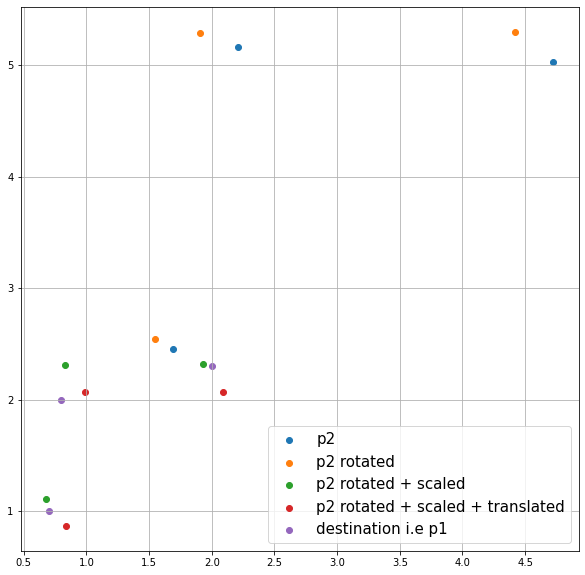

In [335]:
plt.rcParams['figure.figsize'] = 10,10


p_rotating = rotate(p2, rad_angle = transforms[0][1])
p_rotated = rotate(p2, rad_angle = transforms[1][0])

p_rotated_x = p_rotated[:, 0]
p_rotated_y = p_rotated[:, 1]

plt.scatter(p2_x, p2_y, label = "p2")
plt.scatter(p_rotated_x , p_rotated_y, label = "p2 rotated")

p_rotated_x *= transforms[0][0]
p_rotated_y *= transforms[1][1]

plt.scatter(p_rotated_x , p_rotated_y, label = "p2 rotated + scaled")

p_rotated_x += transforms[0][2]
p_rotated_y += transforms[1][2]

plt.scatter(p_rotated_x , p_rotated_y, label = "p2 rotated + scaled + translated")

plt.scatter(p1_x, p1_y, label = "destination i.e p1")

plt.legend(fontsize = 15)
plt.grid()

## Applying the same algorithm to the pattern seen on the distorted image

In [336]:
mat = umeyama(src_points, dst_points, True)[0:2]

print(mat)

[[ 3.88042747e-01 -6.25419056e-04 -1.76410646e+01]
 [ 6.25419056e-04  3.88042747e-01 -1.78865022e+01]]


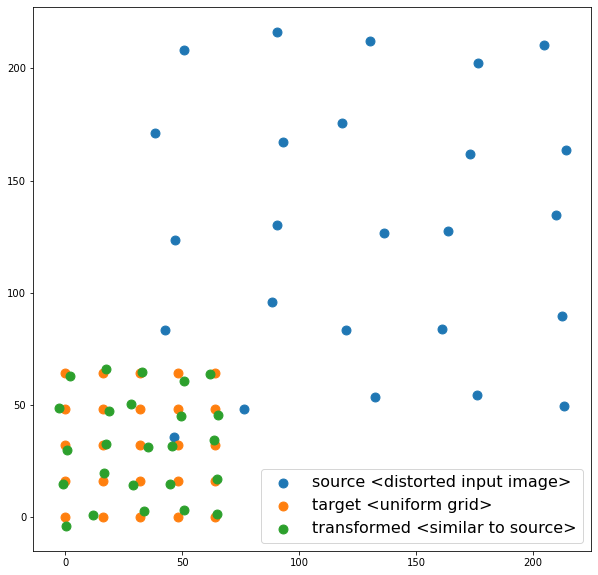

In [337]:
plt.rcParams['figure.figsize'] =10,10

transformed_x , transformed_y = transform(src_points, mat)

plt.scatter(src_points_x, src_points_y, label = "source <distorted input image>", s= 80)
plt.scatter(dst_points_x, dst_points_y, label = "target <uniform grid>", s= 80)
plt.scatter(transformed_x , transformed_y, label = "transformed <similar to source>", s = 80)
plt.legend(fontsize = 16)

# for i in range(len(dst_points_x)):
    
#     x = src_points_x[i]
#     dx =  dst_points_x[i] - x 
    
#     y = src_points_y[i]
#     dy = dst_points_y[i] - y 
    
#     plt.arrow(x,y,dx,dy, linestyle = "--")

## And finally:

We're generating a target image such that it's MSE loss w.r.t the distorted input image is minimized.Thanks to the umeyama algorithm, we are able to do this without distorting the key visual features.

The two important points to note are:
* The target image is similar to the original image
* The set of similarity transformations applied to the original image is such that the MSE loss between the target image and the distorted image has been minimized

(0.0, 255.0)

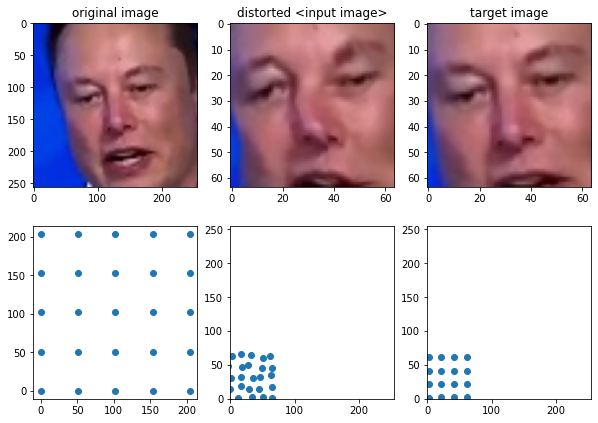

In [350]:
plt.rcParams['figure.figsize'] = 10,7
target_image =cv2.warpAffine(image, mat, (64, 64))#, cv2.COLOR_BGR2RGB)


fig, ax = plt.subplots(nrows=2, ncols=3)

ax.flat[0].imshow(image)
ax.flat[0].set_title("original image")
ax.flat[1].imshow(warped_image)
ax.flat[1].set_title("distorted <input image>")

ax.flat[2].imshow(target_image)
ax.flat[2].set_title("target image")



org_points = np.mgrid[0:255:51, 0:255:51].T.reshape(-1, 2)

org_points_x = org_points[:,0]
org_points_y = org_points[:,1]

ax.flat[3].scatter(org_points_x,org_points_y)


ax.flat[4].scatter(transformed_x, transformed_y)
ax.flat[4].set_ylim(0, 255)
ax.flat[4].set_xlim(0, 255)

target_points_x, target_points_y = transform(org_points, mat)

ax.flat[5].scatter(target_points_x, target_points_y)

ax.flat[5].set_ylim(0, 255)
ax.flat[5].set_xlim(0, 255)